In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping Dataset/file
!unzip /content/drive/MyDrive/PlantVillagecopy.zip

Archive:  /content/drive/MyDrive/PlantVillagecopy.zip
   creating: PlantVillagecopy/
  inflating: __MACOSX/._PlantVillagecopy  
   creating: PlantVillagecopy/Tomato_healthy/
  inflating: __MACOSX/PlantVillagecopy/._Tomato_healthy  
   creating: PlantVillagecopy/Tomato_Early_blight/
  inflating: __MACOSX/PlantVillagecopy/._Tomato_Early_blight  
  inflating: PlantVillagecopy/.DS_Store  
  inflating: __MACOSX/PlantVillagecopy/._.DS_Store  
   creating: PlantVillagecopy/Tomato__Target_Spot/
  inflating: __MACOSX/PlantVillagecopy/._Tomato__Target_Spot  
   creating: PlantVillagecopy/Tomato_Leaf_Mold/
  inflating: __MACOSX/PlantVillagecopy/._Tomato_Leaf_Mold  
   creating: PlantVillagecopy/Tomato_Spider_mites/
  inflating: __MACOSX/PlantVillagecopy/._Tomato_Spider_mites  
   creating: PlantVillagecopy/Tomato__mosaic_virus/
  inflating: __MACOSX/PlantVillagecopy/._Tomato__mosaic_virus  
   creating: PlantVillagecopy/Tomato_Septoria_leaf_spot/
  inflating: __MACOSX/PlantVillagecopy/._Tomato_Se

In [ ]:
# Installing tensorflow_addons
%pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 


# **Importing all necessary libraries**



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Tensorflow Version
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.9.2


# **Define some parameters for the loader**

In [ ]:
# Declaring default Image size, Batch size and Number of classes
IMAGE_SIZE = 256
BATCH_SIZE = 16
n_classes = 10

# **Generates a tf.data.Dataset from image files in a directory.**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillagecopy",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 991 files belonging to 10 classes.


In [ ]:
# Extracting classes/labels from dataset
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites',
 'Tomato__Target_Spot',
 'Tomato__YellowLeaf_Curl_Virus',
 'Tomato__mosaic_virus',
 'Tomato_healthy']

# **Data Augmentations**




In [ ]:
def data_augment(image):
    # Outputs random values from a uniform distribution
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Randomly flips an image horizontally(left to right)
    image = tf.image.random_flip_left_right(image)
    # Randomly flips an image vertically (upside down)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image) # Transpose image by swapping the height and width dimension
        
    # Rotating images
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # Rotating image Counter Clockwise by 270º  
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # Rotating image Counter Clockwise by 180º 
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # Rotating image Counter Clockwise by 90º 
        
    return image

# **Image Data Generator**

In [ ]:
# Generate batches of tensor image data with real-time data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

# using flow_from_directory method of ImageDataGenerator
train_gen = datagen.flow_from_directory("PlantVillagecopy", 
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                        color_mode='rgb', 
                                        class_mode='categorical', 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        seed=1,
                                        subset='training')

valid_gen = datagen.flow_from_directory("PlantVillagecopy", 
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                        color_mode='rgb', 
                                        class_mode='categorical', 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=False, 
                                        seed=1,
                                        subset='validation')

test_gen = datagen.flow_from_directory("PlantVillagecopy", 
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                       color_mode='rgb', 
                                       class_mode=None, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       seed=1)

Found 793 images belonging to 10 classes.
Found 198 images belonging to 10 classes.
Found 991 images belonging to 10 classes.


# **Image Visualization**

1.   Sample images with labels
2.   Sample image visualization



### **1. Sample images with labels**

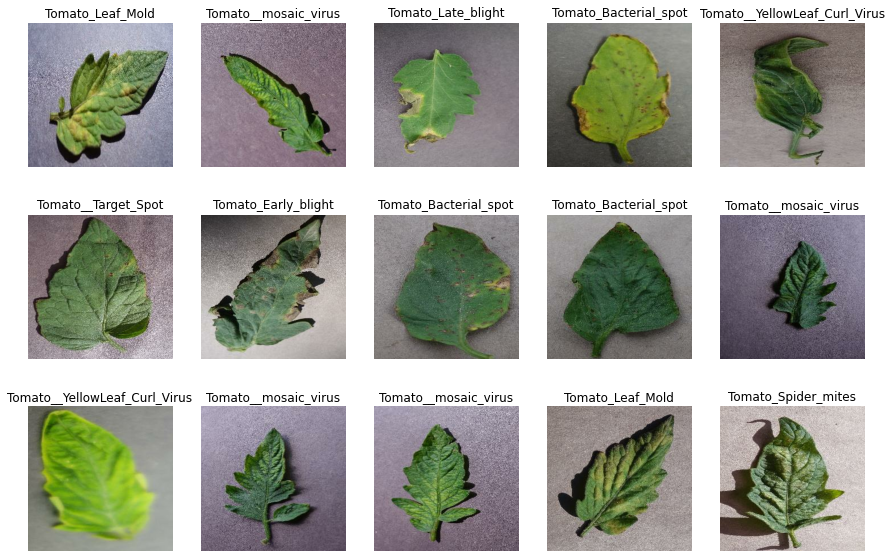

In [ ]:
plt.figure(figsize = (15, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(3, 5, i+1) # Create a figure and a set of subplots
        plt.imshow(image_batch[i].numpy().astype("uint8")) #It converts whatever you give it to a 8 bit integer (from 0 to 255) by a modulo 256 operation
        plt.title(class_names[label_batch[i]])
        plt.axis('off') # Turning off axes values

### **2. Sample Image Visualization**

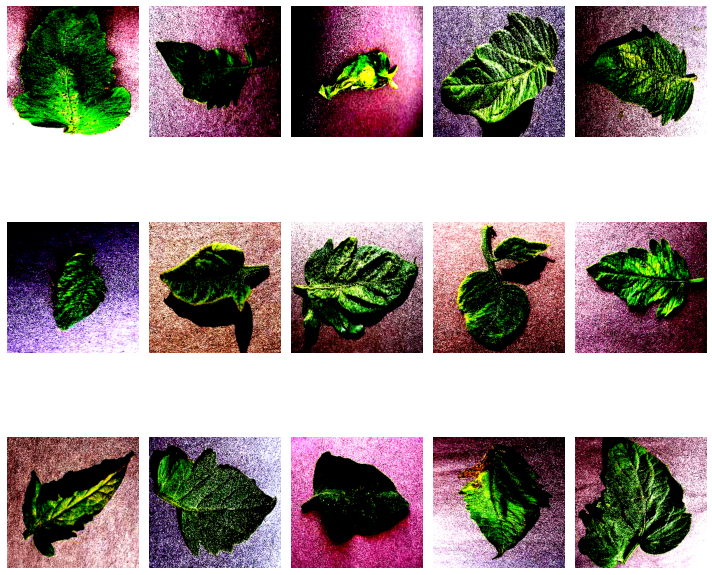

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10)) # Create a figure and a set of subplots

# axes.flatten(), where flatten() is method of the numpy array. Instead of an iterator, it returns a flattened version of the array
axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off') # Turning off axes values

plt.tight_layout() # Adjust the padding between and around subplots
plt.show() # Display all open figures

# **Model Hyperparameters**

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 300

patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

# **Building the Model and it's Components**

1.   Multilayer Perceptron (MLP)
2.   Patch Creation Layer
3.   Patch Encoding Layer






### **1.   Multilayer Perceptron (MLP)**

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x) # Just your regular densely-connected NN layer
        x = L.Dropout(dropout_rate)(x) # Applies Dropout to the input
    return x

### **2. Patch Creation Layer**

In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # Returns a tensor containing the shape of the input tensor
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        ) # Extract patches from images

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # Reshapes a tensor
        return patches

# **Sample Image Patches Visualization**

Image size: 256 X 256
Patch size: 8 X 8
Patches per image: 1024
Elements per patch: 192


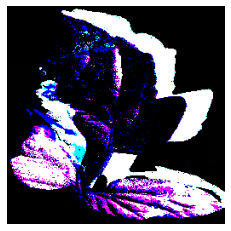

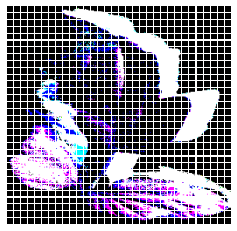

In [ ]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8')) # Display data as an image, i.e., on a 2D regular raster
plt.axis('off') # Turning off axes values 

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (IMAGE_SIZE, IMAGE_SIZE)
) # Resize images to size using the specified method

patches = Patches(patch_size)(resized_image)
print(f'Image size: {IMAGE_SIZE} X {IMAGE_SIZE}') # Printing Image size
print(f'Patch size: {patch_size} X {patch_size}') # Printing Patch size
print(f'Patches per image: {patches.shape[1]}') # Printing Patches per image
print(f'Elements per patch: {patches.shape[-1]}') # Printing Elements per patch

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4)) # Create a new figure, or activate an existing figure

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1) # Create a figure and a set of subplots
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3)) # Reshapes a tensor
    plt.imshow(patch_img.numpy().astype('uint8')) # Display data as an image, i.e., on a 2D regular raster
    plt.axis('off') # Turning off axes values

### **3. Patch Encoding Layer**

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# **Build the ViT model**


In [ ]:
def vision_transformer():
    inputs = L.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(n_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [ ]:
decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate

# A LearningRateSchedule that uses a cosine decay schedule
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Optimizer that implements the Adam algorithm

model = vision_transformer()

# Compiling model - The compile() method specifying a loss, metrics, and an optimizer
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

# EarlyStopping : Stop training when a monitored metric has stopped improving
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 301,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

# Checkpoint : Callback to save the Keras model or model weights at some frequency
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, lr_scheduler, checkpointer]

# Training Model - We call fit(), which will train the model by slicing the data into "batches" of size batch_size, and repeatedly iterating over the entire dataset for a given number of epochs
r = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)

Epoch 1/300
49/49 [==============================] - ETA: 0s - loss: 6.6363 - accuracy: 0.1133
Epoch 1: val_accuracy improved from -inf to 0.07292, saving model to ./model.hdf5
49/49 [==============================] - 45s 675ms/step - loss: 6.6363 - accuracy: 0.1133 - val_loss: 4.6906 - val_accuracy: 0.0729 - lr: 0.0010
Epoch 2/300
49/49 [==============================] - ETA: 0s - loss: 6.5655 - accuracy: 0.1055
Epoch 2: val_accuracy did not improve from 0.07292
49/49 [==============================] - 33s 671ms/step - loss: 6.5655 - accuracy: 0.1055 - val_loss: 5.6388 - val_accuracy: 0.0729 - lr: 9.9897e-04
Epoch 3/300
49/49 [==============================] - ETA: 0s - loss: 6.9086 - accuracy: 0.0991
Epoch 3: val_accuracy did not improve from 0.07292
49/49 [==============================] - 33s 683ms/step - loss: 6.9086 - accuracy: 0.0991 - val_loss: 8.5088 - val_accuracy: 0.0729 - lr: 9.9590e-04
Epoch 4/300
49/49 [==============================] - ETA: 0s - loss: 7.5844 - accuracy: 

# **Model Results**

In [ ]:
# Evaluate the model on the training data using `evaluate`
print('Training results')
model.evaluate(train_gen)

# Evaluate the model on the validation data using `evaluate`
print('Validation results')
model.evaluate(valid_gen)

Training results
50/50 [==============================] - 13s 267ms/step - loss: 7.3199 - accuracy: 0.1274
Validation results
13/13 [==============================] - 3s 255ms/step - loss: 7.8100 - accuracy: 0.1162


[7.810033321380615, 0.11616161465644836]

# **Plotting Graphs of Loss and Accuracy**

Training loss and Validation loss


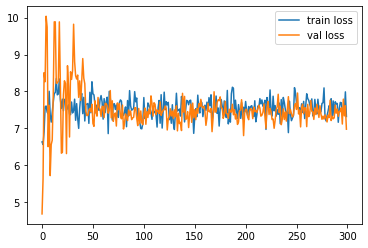

Training accuracy and Validation accuracy


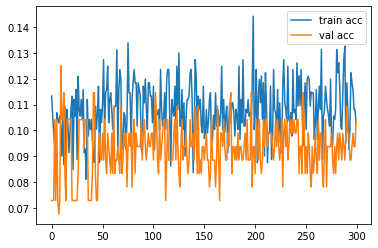

<Figure size 432x288 with 0 Axes>

In [ ]:
# plotting training loss and validation loss
print('Training loss and Validation loss')
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend() # Placing a legend on the Axes
plt.show() # Displaying all open figures
plt.savefig('LossVal_loss') # Saving the current figure

# plotting training accuracy and validation accuracy
print('Training accuracy and Validation accuracy')
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend() # Placing a legend on the Axes
plt.show() # Displaying all open figures
plt.savefig('AccVal_acc') # Saving the current figure

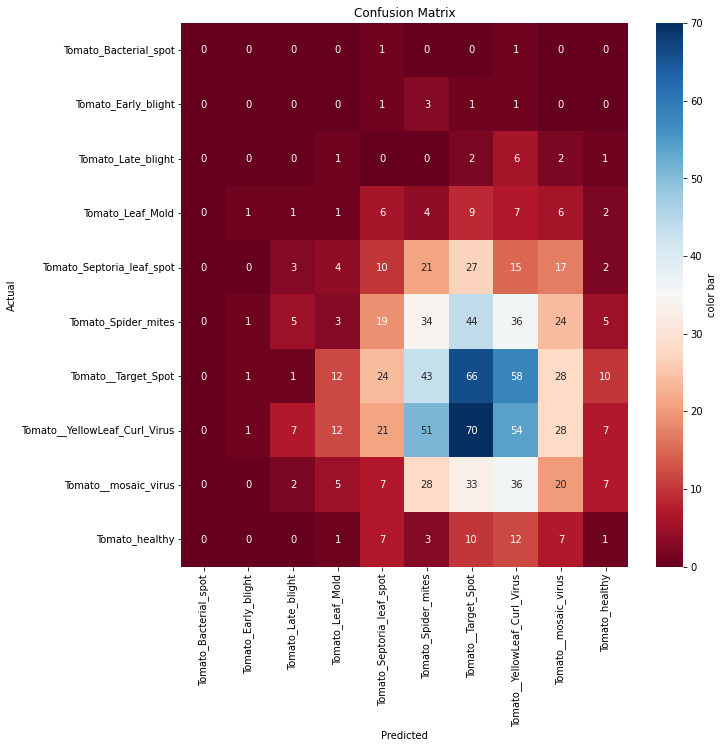

In [ ]:
# --- confusion matrix
from sklearn.metrics import confusion_matrix
actual = numpy.random.binomial(len(class_names)*2,.85,size = 1000)
predicted = numpy.random.binomial(len(class_names)*2,.85,size = 1000)

confusion_matrix = metrics.confusion_matrix(actual, predicted)
# --- ---- ---- heatmap
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(confusion_matrix,cmap="RdBu",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"}, fmt = 'd', ax = ax,
            xticklabels=['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites','Tomato__Target_Spot','Tomato__YellowLeaf_Curl_Virus','Tomato__mosaic_virus','Tomato_healthy'],yticklabels=['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites','Tomato__Target_Spot','Tomato__YellowLeaf_Curl_Virus','Tomato__mosaic_virus','Tomato_healthy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Prediction**

In [ ]:
# Image directory/path
img_dir = "/content/PlantVillagecopy/Tomato_healthy/Tomato_healthy_1.JPG"

# Loading an image into PIL format
img = tf.keras.utils.load_img(
    img_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Converting a PIL Image instance to a Numpy array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(img_array) # model.predict() – A model can be created and fitted with trained data, and used to make a prediction
score = tf.nn.softmax(predictions[0]) # Computing softmax activations

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 57ms/step
[[ 193.8082   -362.8927   -413.30618   150.17105   -51.24889  -450.65848
    13.857543 -194.15662    48.37727   693.9175  ]]
This image most likely belongs to Tomato_healthy with a 100.00 percent confidence.
